# FastHugs
This notebook gives a full run through to fine-tune a text classification model with **HuggingFace 🤗 transformers** and the new **fastai-v2** library.

## Things You Might Like (❤️ ?)
**FastHugsTokenizer:** A tokenizer wrapper than can be used with fastai-v2's tokenizer.

**FastHugsModel:** A model wrapper over the HF models, more or less the same to the wrapper's from HF fastai-v1 articles mentioned below

**Vocab:** A function to extract the vocab depending on the pre-trained transformer (HF hasn't standardised this processes 😢).

**Padding:** Padding settings for the padding token index and on whether the transformer prefers left or right padding

**Vocab for Albert-base-v2**: .json for Albert-base-v2's vocab, otherwise this has to be extracted from a SentencePiece model file, which isn't fun

**Model Splitters:** Functions to split the classification head from the model backbone in line with fastai-v2's new definition of `Learner`

## Housekeeping
### Pretrained Transformers only for now 😐
Initially, this notebook will only deal with finetuning HuggingFace's pretrained models. It covers BERT, DistilBERT, RoBERTa and ALBERT pretrained classification models only. These are the core transformer model architectures where HuggingFace have added a classification head. HuggingFace also has other versions of these model architectures such as the core model architecture and language model model architectures.

If you'd like to try train a model from scratch HuggingFace just recently published an article on [How to train a new language model from scratch using Transformers and Tokenizers](https://huggingface.co/blog/how-to-train). Its well worth reading to see how their `tokenizers` library can be used, independent of their pretrained transformer models.

### Read these first 👇
This notebooks heavily borrows from [this notebook](https://www.kaggle.com/melissarajaram/roberta-fastai-huggingface-transformers) , which in turn is based off of this [tutorial](https://www.kaggle.com/maroberti/fastai-with-transformers-bert-roberta) and accompanying [article](https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2). Huge thanks to  Melissa Rajaram and Maximilien Roberti for these great resources, if you're not familiar with the HuggingFace library please given them a read first as they are quite comprehensive.

### fastai-v2  ✌️2️⃣
[This paper](https://www.fast.ai/2020/02/13/fastai-A-Layered-API-for-Deep-Learning/) introduces the v2 version of the fastai library and you can follow and contribute to v2's progress [on the forums](https://forums.fast.ai/). This notebook uses the small IMDB dataset and is based off the [fastai-v2 ULMFiT tutorial](http://dev.fast.ai/tutorial.ulmfit). Huge thanks to Jeremy, Sylvain, Rachel and the fastai community for making this library what it is. I'm super excited about the additinal flexibility v2 brings. 🎉

### Dependencies 📥
If you haven't already, install HuggingFace's `transformers` library with: `pip install transformers`

In [3]:
#hide
# CUDA ERROR DEBUGGING
# https://lernapparat.de/debug-device-assert/
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
#hide
%reload_ext autoreload
%autoreload 2

from fastai2.basics import *
from fastai2.text.all import *
from fastai2.callback.all import *

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import AlbertForSequenceClassification, AlbertTokenizer, AlbertConfig

import json

In [5]:
#hide
path = untar_data(URLs.IMDB_SAMPLE)
model_path = Path('models')
df = pd.read_csv(path/'texts.csv')

## FastHugs Tokenizer
This tokenizer wrapper is initialised with the pretrained HF tokenizer, you can also specify the max_seq_len if you want longer/shorter sequences. Given text it returns tokens and adds separator tokens depending on the model type being used.

In [6]:
class FastHugsTokenizer():
    """ 
        transformer_tokenizer : takes the tokenizer that has been loaded from the tokenizer class
        model_type : model type set by the user
        max_len : override default sequence length, typically 512 for bert-like models
    """
    def __init__(self, transformer_tokenizer, model_type = 'roberta', max_seq_len=None, **kwargs): 
        self.tok = transformer_tokenizer
        self.max_seq_len = ifnone(max_seq_len, self.tok.max_len)
        self.model_type = model_type
        self.pad_token_id = self.tok.pad_token_id
        
    def do_tokenize(self, t:str):
        """Limits the maximum sequence length and add the special tokens"""
        CLS = self.tok.cls_token
        SEP = self.tok.sep_token
#         import pdb
#         pdb.set_trace()
        #print(t)
        if 'roberta' in model_type:
            tokens = self.tok.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self.tok.tokenize(t)[:self.max_seq_len - 2]
        #print(tokens)
        return [CLS] + tokens + [SEP]

    def __call__(self, items): 
        for t in items: yield self.do_tokenize(t)

## FastHugs Model
This `nn.module` wraps the pretrained transformer model, initialises it with is config file. If you'd like to make configuration changes to the model, you can do so in this class. The `forward` of this module is taken straight from Melissa's notebook above and its purpose is to create the attention mask and grab only the logits from the output of the model (as the HF transformer models also output the loss).

In [7]:
# More or less copy-paste from https://www.kaggle.com/melissarajaram/roberta-fastai-huggingface-transformers/data
class FastHugsModel(nn.Module):
    def __init__(self, pretrained_model_name, model_class, config_class, n_class, max_seq_len=None):
        super(FastHugsModel, self).__init__()
        self.config = config_class.from_pretrained(pretrained_model_name)
        self.config.num_labels = n_class
        if max_seq_len is not None: self.config.max_position_embeddings = max_len
        
        self.transformer = model_class.from_pretrained(pretrained_model_name, config = self.config, 
                                    cache_dir=model_path/f'{pretrained_model_name}')
        
    def forward(self, input_ids, attention_mask=None):
        attention_mask = (input_ids!=1).type(input_ids.type()) 
        logits = self.transformer(input_ids, attention_mask = attention_mask)[0] 
        return logits

## Padding
Pass the initialised transformer tokenizer to set the index for the padding token and the side padding should be applied; e.g. BERT, Roberta prefers padding to the right, so we set `pad_first=False`

In [8]:
def transformer_padding(transformer_tokenizer): 
    if transformer_tokenizer.padding_side == 'right': 
        pad_first=False
    return partial(pad_input_chunk, pad_first=pad_first, pad_idx=transformer_tokenizer.pad_token_id)

## Lets get training
### Select our HuggingFace model

In [9]:
models_dict = {'bert_classification': (BertForSequenceClassification, BertTokenizer, BertConfig, 
                                       'bert-base-uncased', 'bert_class_splitter'),
                'roberta_classification': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig, 
                                           'roberta-base', 'roberta_clas_splitter'),
                'distilbert_classification': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig, 
                                              'distilbert-base-uncased', 'distilbert_clas_splitter'),
                'albert_classification': (AlbertForSequenceClassification, AlbertTokenizer, AlbertConfig, 
                                          'albert-base-v2', 'albert_clas_splitter')
              }

Grab the model, tokenizer and config that we'd like to use

In [10]:
model_type = 'roberta_classification'  
model_class, tokenizer_class, config_class, pretrained_model_name, tfmr_splitter = models_dict[model_type]

We can also change the max sequence length for the tokenizer and transformer here. If its not set it will default to the pretrained model's default, typically `512`. 1024 or even 2048 can also be used depending on your GPU memory

In [11]:
max_seq_len = None  

## Geting HuggingFace Tokenizer into fastai-v2
Intialise the tokenizer needed for the pretrained model, this will download the `vocab.json` and `merges.txt` files needed. Specifying `cache_dir` will allow us easily access them, otherwise they will be saved to a Torch cache folder here `~/.cache/torch/transformers`. 

In [12]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name, 
                                                        cache_dir=model_path/f'{pretrained_model_name}')

**Create fasthugstok function:** Lets incorporate the `transformer_tokenizer` into fastai-v2's framework by specifying a fucntion to pass to `Tokenizer.from_df`. (Note `from_df` is the only method I have tested)

In [13]:
fasthugstok = partial(FastHugsTokenizer, transformer_tokenizer = transformer_tokenizer, 
                      model_type=model_type, max_seq_len=None)

**Set up fastai-v2's Tokenizer.from_df:** We pass `rules=[]` to override fastai's default text processing rules

In [16]:
tok_fn = Tokenizer.from_df(text_cols='text', res_col_name='text', tok_func=fasthugstok, rules=[])

 ## Vocab
 Model and vocab files will be saved with files names as a long string of digits and letters (e.g. `d9fc1956a0....f4cfdb5feda.json` generated from the etag from the AWS S3 bucket as described [here in the HuggingFace repo](https://github.com/huggingface/transformers/issues/2157). For readability I prefer to save the files in a specified directory and model name so that it can be easily found and accessed in future.
 
(Note: To avoid saving these files twice you could look at the `from_pretrained` and `cached_path` functions in HuggingFace's `PreTrainedTokenizer` class definition to find the code that downloads the files and maybe modify them to download directly to your specified directory withe desired name. I haven't had time to go that deep.)

Load vocab file into a `list` as expected by fastai-v2. The HF pretrained tokenizer vocabs come in different file formats depending on the tokenizer you're using; BERT's vocab is saved as a .txt file, RoBERTa's is saved as a .json and Albert's has to be extracted from a SentencePiece model

In [17]:
def get_vocab(transformer_tokenizer, pretrained_model_name):
    if pretrained_model_name in ['bert-base-uncased', 'distilbert-base-uncased']:
        transformer_vocab = list(transformer_tokenizer.vocab.keys())
    else:
        transformer_tokenizer.save_vocabulary(model_path/f'{pretrained_model_name}')
        suff = 'json'
        if pretrained_model_name in ['albert-base-v2']:
            with open(model_path/f'{pretrained_model_name}/alberta_v2_vocab.{suff}', 'r') as f: 
                transformer_vocab = json.load(f) 
        else:
            with open(model_path/f'{pretrained_model_name}/vocab.{suff}', 'r') as f: 
                transformer_vocab = list(json.load(f).keys()) 
    return transformer_vocab

In [18]:
transformer_vocab = get_vocab(transformer_tokenizer, pretrained_model_name)

## Setup Data
### Create Dataset
Lets add our custom tokenizer function (`tok_fn`) and `transformer_vocab` here

In [19]:
splits = ColSplitter()(df)
x_tfms = [attrgetter("text"), tok_fn, Numericalize(vocab=transformer_vocab)]
dsets = Datasets(df, splits=splits, tfms=[x_tfms, [attrgetter("label"), Categorize()]], dl_type=SortedDL)

### Dataloaders
Here we use our `transformer_padding()` wrapper when loading the dataloader

In [20]:
bs = 4
dls = dsets.dataloaders(bs=bs, device='cuda', before_batch=transformer_padding(transformer_tokenizer))

In [21]:
dls.show_batch(max_n=5)

,text,category
0,"<s> ĠI Ġwas Ġfortunate Ġenough Ġto Ġmeet ĠGeorge ĠPal Ġ( and Ġstill Ġhave Ġmy ĠDS : TM OB Ġposter Ġaut ographed Ġby Ġhim ) Ġat Ġa Ġconvention Ġshortly Ġafter Ġthe Ġrelease , Ġand Ġasked Ġhim Ġwhy Ġhe Ġchose Ġto Ġdo Ġthe Ġfilm Ġ"" camp "". ĠBefore Ġhe Ġcould Ġanswer , Ġtwo Ġstudio Ġfl acks Ġintercepted Ġand Ġlect ured Ġme Ġon Ġhow Ġthe Ġstudio Ġ"" k new Ġbest "" Ġand Ġhow Ġ"" no Ġone Ġwill Ġtake Ġsuch Ġa Ġfilm Ġseriously "". ĠI Ġhad Ġbeen Ġreading Ġthe ĠB antam Ġre prints Ġfor Ġa Ġcouple Ġof Ġyears Ġthanks Ġto Ġa Ġfriend Ġ( Com i Con Ġattendees Ġof Ġthe Ġ1970 s Ġwill Ġrecall ĠBlack hawk Ġand Ġhis Ġband ? ĠI Ġwas Ġin Ġa Ġcouple Ġof Ġyears Ġof Ġthat Ġwith Ġhim ), Ġand Ġhad Ġhigher Ġhopes Ġthan Ġwhat Ġwe Ġgot .< br Ġ/ >< br Ġ/> The Ġfl acks Ġinsisted Ġthat Ġno Ġhigh Ġadventure Ġwould",negative
1,"<s> ĠNow Ġthat ĠChe ( 2008 ) Ġhas Ġfinished Ġits Ġrelatively Ġshort ĠAustralian Ġcinema Ġrun Ġ( extremely Ġlimited Ġrelease : 1 Ġscreen Ġin ĠSydney , Ġafter Ġ6 w ks ), ĠI Ġcan Ġguilt lessly Ġjoin Ġboth Ġhosts Ġof Ġ"" At ĠThe ĠMovies "" Ġin Ġtaking ĠSteven ĠS oder ber gh Ġto Ġtask .< br Ġ/ >< br Ġ/> It 's Ġusually Ġsatisfying Ġto Ġwatch Ġa Ġfilm Ġdirector Ġchange Ġhis Ġstyle / subject , Ġbut ĠS oder ber gh 's Ġmost Ġrecent Ġst inker , ĠThe ĠG irlfriend ĠExperience ( 2009 ), Ġwas Ġalso Ġmissing Ġa Ġstory , Ġso Ġnarrative Ġ( and Ġediting ?) Ġseem Ġto Ġsuddenly Ġbe ĠS oder ber gh 's Ġmain Ġchallenge . ĠStrange , Ġafter Ġ20 - odd Ġyears Ġin Ġthe Ġbusiness . ĠHe Ġwas Ġprobably Ġnever Ġmuch Ġgood Ġat Ġnarrative , Ġjust Ġhid Ġit Ġwell Ġinside Ġ"" ed gy "" Ġprojects .< br Ġ/ >< br",negative
2,"<s> ĠThere 's Ġno Ġdenying Ġthe Ġfirst ĠAz umi Ġfilm Ġwas Ġa Ġcommercial Ġproduct ; Ġit Ġwas Ġan Ġadaptation Ġof Ġa Ġpopular Ġmanga Ġand Ġhad Ġcast Ġof Ġyoung , Ġattractive Ġactors Ġand Ġcertainly Ġwasn 't Ġlacking Ġin Ġthe Ġbudget Ġdepartment . ĠYet Ġit Ġmore Ġthan Ġentertained Ġfor Ġwhat Ġit Ġwas , Ġand ĠI Ġcan 't Ġdeny ĠI Ġenjoyed Ġit Ġimmensely .< br Ġ/ >< br Ġ/> "" Az umi Ġ2 "" Ġlacks Ġjust Ġabout Ġeverything Ġthat Ġmade Ġthe Ġoriginal Ġso Ġwonderful . ĠThe Ġfirst Ġthing Ġthat Ġshould Ġset Ġalarm Ġbells Ġringing Ġis Ġthe Ġabsence Ġof Ġthe Ġsuperb ĠRyu hei ĠKit amura Ġat Ġthe Ġhelm . ĠWith Ġhim , Ġhe Ġseemed Ġto Ġtake Ġnot Ġonly Ġhis Ġown Ġvisual Ġflair Ġand Ġkin etics , Ġbut Ġthe Ġoriginals Ġstyle , Ġbeauty Ġand Ġmost Ġimportantly , Ġits Ġheart . ĠWhile Ġthe Ġfirst Ġhad Ġa Ġsimple Ġ"" hit list "" Ġplot , Ġthis Ġone Ġhas",negative
3,"<s> ĠThe Ġproblem Ġwith Ġ"" The ĠKiller ĠElite "" Ġis Ġthat Ġjust Ġby Ġseeking Ġthis Ġfilm Ġout , Ġand Ġinvesting Ġtime Ġto Ġwatch Ġit , Ġyou Ġare Ġputting Ġmore Ġeffort Ġinto Ġthe Ġexperience Ġthan Ġmany Ġof Ġits Ġprincipals Ġdid , Ġparticularly Ġdirector ĠSam ĠPeck in p ah .< br Ġ/ >< br Ġ/> The Ġalready Ġvolatile ĠPeck in p ah Ġwas Ġheading Ġinto Ġrough Ġweather Ġwith Ġthis Ġfilm . ĠAccording Ġto Ġat Ġleast Ġone Ġbi ographer , Ġthis Ġwas Ġwhere Ġhe Ġbecame Ġacquainted Ġwith Ġcocaine . ĠAdd Ġto Ġthat Ġhis Ġbinge Ġdrinking , Ġand Ġit 's Ġno Ġwonder Ġthings Ġfell Ġapart .< br Ġ/ >< br Ġ/> It 's Ġa Ġshame , Ġbecause Ġthe Ġconcept Ġbehind Ġthe Ġfilm Ġis Ġa Ġgood Ġone , Ġand Ġthe Ġfirst Ġten Ġminutes Ġpromise Ġmuch . ĠMike ĠLock en Ġ( James ĠCa an ) Ġand ĠGeorge ĠHansen Ġ( Robert ĠDu v all ) Ġare Ġprivate",negative


### (Alternatively) Factory dataloader
Here we set:
- `tok_tfm=tok_fn` to use our HF tokenizer
- `text_vocab=transformer_vocab` to load our pretrained vocab
- `before_batch=transformer_padding(transformer_tokenizer)` to use our custom padding function 

In [19]:
# Factory
fct_dls = TextDataLoaders.from_df(df, text_col="text", tok_tfm=tok_fn, text_vocab=transformer_vocab,
                              before_batch=transformer_padding(transformer_tokenizer),
                              label_col='label', valid_col='is_valid', bs=bs)

In [20]:
fct_dls.show_batch(max_n=2, trunc_at=60)

,text,category
0,"<s> ĠI Ġwas Ġfortunate Ġenough Ġto Ġmeet ĠGeorge ĠPal Ġ( and Ġstill Ġhave Ġmy ĠDS : TM OB Ġposter Ġaut ographed Ġby Ġhim ) Ġat Ġa Ġconvention Ġshortly Ġafter Ġthe Ġrelease , Ġand Ġasked Ġhim Ġwhy Ġhe Ġchose Ġto Ġdo Ġthe Ġfilm Ġ"" camp "". ĠBefore Ġhe Ġcould Ġanswer , Ġtwo Ġstudio Ġfl acks Ġintercepted Ġand Ġlect ured Ġme Ġon",negative
1,"<s> ĠOnce Ġupon Ġa Ġtime Ġin Ġa Ġcastle ...... ĠTwo Ġlittle Ġgirls Ġare Ġplaying Ġin Ġthe Ġgarden 's Ġcastle . ĠThey Ġare Ġsisters . ĠA Ġblonde Ġlittle Ġgirl Ġ( K itty ) Ġand Ġa Ġbrun ette Ġone Ġ( E ve lyn ). ĠEve lyn Ġsteals ĠKitty 's Ġdoll . ĠKitty Ġpurs ues ĠEve lyn . ĠRunning Ġthrough Ġlong Ġcorridors ,",positive


## Model Splitters
HuggingFace's models with names such as: `RobertaForSequenceClassification` are core transformer models with a classification head. Lets split the classification head from the core transformer backbone to enable us use progressive unfreezing and differential learning rates.

You can split the model into 3 groups by modifying the splitter function like so:

`
def roberta_clas_splitter(m):
    "Split the classifier head from the backbone"
    groups = [nn.Sequential(m.transformer.roberta.embeddings,
                  m.transformer.roberta.encoder.layer[0],
                  m.transformer.roberta.encoder.layer[1],
                  m.transformer.roberta.encoder.layer[2],
                  m.transformer.roberta.encoder.layer[3],
                  m.transformer.roberta.encoder.layer[4],
                  m.transformer.roberta.encoder.layer[5],
                  m.transformer.roberta.encoder.layer[6],
                  m.transformer.roberta.encoder.layer[7],
                  m.transformer.roberta.encoder.layer[8])]
    groups+= [nn.Sequential(m.transformer.roberta.encoder.layer[9],
                  m.transformer.roberta.encoder.layer[10],
                  m.transformer.roberta.encoder.layer[11],
                  m.transformer.roberta.pooler)]
    groups = L(groups + [m.transformer.classifier])
    return groups.map(params)
`

**Classification Head Differences**

Interestingly, BERT's classification head is different to RoBERTa's

BERT + ALBERT:

`
(dropout): Dropout(p=0.1, inplace=False)
(classifier): Linear(in_features=768, out_features=2, bias=True)
`

DistilBERT's has a "pre-classifier" layer:

`
(pre_classifier): Linear(in_features=768, out_features=768, bias=True)
(classifier): Linear(in_features=768, out_features=2, bias=True)
(dropout): Dropout(p=0.2, inplace=False)`

RoBERTa's:

`(classifier): RobertaClassificationHead(
    (dense): Linear(in_features=768, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (out_proj): Linear(in_features=768, out_features=2, bias=True))`

In [21]:
def bert_clas_splitter(m):
    "Split the classifier head from the backbone"
    groups = [nn.Sequential(m.transformer.bert.embeddings,
                m.transformer.bert.encoder.layer[0],
                m.transformer.bert.encoder.layer[1],
                m.transformer.bert.encoder.layer[2],
                m.transformer.bert.encoder.layer[3],
                m.transformer.bert.encoder.layer[4],
                m.transformer.bert.encoder.layer[5],
                m.transformer.bert.encoder.layer[6],
                m.transformer.bert.encoder.layer[7],
                m.transformer.bert.encoder.layer[8],
                m.transformer.bert.encoder.layer[9],
                m.transformer.bert.encoder.layer[10],
                m.transformer.bert.encoder.layer[11],
                m.transformer.bert.pooler)]
    groups = L(groups + [m.transformer.classifier]) 
    return groups.map(params)

In [22]:
def albert_clas_splitter(m):
    groups = [nn.Sequential(m.transformer.albert.embeddings,
                m.transformer.albert.encoder.embedding_hidden_mapping_in, 
                m.transformer.albert.encoder.albert_layer_groups,
                m.transformer.albert.pooler)]
    groups = L(groups + [m.transformer.classifier]) 
    return groups.map(params)

In [23]:
def distilbert_clas_splitter(m):
    groups = [nn.Sequential(m.transformer.distilbert.embeddings,
                m.transformer.distilbert.transformer.layer[0], 
                m.transformer.distilbert.transformer.layer[1],
                m.transformer.distilbert.transformer.layer[2],
                m.transformer.distilbert.transformer.layer[3],
                m.transformer.distilbert.transformer.layer[4],
                m.transformer.distilbert.transformer.layer[5],
                m.transformer.pre_classifier)]
    groups = L(groups + [m.transformer.classifier]) 
    return groups.map(params)

In [24]:
def roberta_clas_splitter(m):
    "Split the classifier head from the backbone"
    groups = [nn.Sequential(m.transformer.roberta.embeddings,
                  m.transformer.roberta.encoder.layer[0],
                  m.transformer.roberta.encoder.layer[1],
                  m.transformer.roberta.encoder.layer[2],
                  m.transformer.roberta.encoder.layer[3],
                  m.transformer.roberta.encoder.layer[4],
                  m.transformer.roberta.encoder.layer[5],
                  m.transformer.roberta.encoder.layer[6],
                  m.transformer.roberta.encoder.layer[7],
                  m.transformer.roberta.encoder.layer[8],
                  m.transformer.roberta.encoder.layer[9],
                  m.transformer.roberta.encoder.layer[10],
                  m.transformer.roberta.encoder.layer[11],
                  m.transformer.roberta.pooler)]
    groups = L(groups + [m.transformer.classifier])
    return groups.map(params)

In [25]:
splitters = {'bert_clas_splitter':bert_clas_splitter,
            'albert_clas_splitter':albert_clas_splitter,
            'distilbert_clas_splitter':distilbert_clas_splitter,
            'roberta_clas_splitter':roberta_clas_splitter}

### Load Model with configs

Here we can tweak the HuggingFace model's config file before loading the model

In [26]:
fasthugs_model = FastHugsModel(model_class=model_class, config_class=config_class,
                               pretrained_model_name = pretrained_model_name, 
                               n_class=dsets.c, max_seq_len=max_seq_len)

Initialise everything our Learner

In [27]:
opt_func = partial(Adam, decouple_wd=True)

cbs = [MixedPrecision(clip=0.1), SaveModelCallback()]

loss = CrossEntropyLossFlat() #LabelSmoothingCrossEntropy

splitter = splitters[tfmr_splitter]

## Time to train
### Create our learner

In [28]:
learn = Learner(dls, fasthugs_model, opt_func=opt_func, splitter=splitter, loss_func=loss, cbs=cbs, metrics=[accuracy])

### Stage 1 training
Lets freeze the model backbone and only train the classifier head. `freeze_to(1)` means that only the classifier head is trainable

In [29]:
learn.freeze_to(1)  

In [30]:
#learn.summary()

Lets find a learning rate to train our classifier head

(6.918309954926372e-05, 0.04786301031708717)

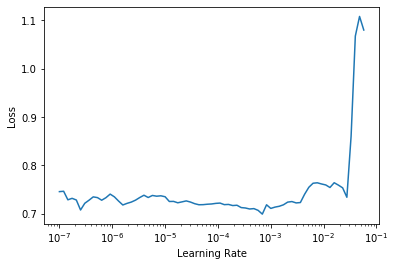

In [31]:
learn.lr_find(suggestions=True)

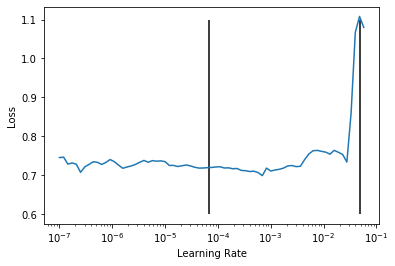

In [32]:
learn.recorder.plot_lr_find()
plt.vlines(6.918e-05, 0.6, 1.1)
plt.vlines(0.04786, 0.6, 1.1)

In [33]:
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.693150,0.632017,0.635000,00:13
1,0.484624,0.491484,0.765000,00:12
2,0.493592,0.463320,0.780000,00:13


In [34]:
learn.save('roberta-fasthugs-stg1-1e-3')

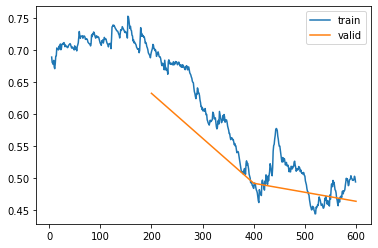

In [35]:
learn.recorder.plot_loss()

### Stage 2 training
And now lets train the full model with differential learning rates

In [36]:
learn.unfreeze()

In [37]:
#learn.summary()

(2.5118865210060903e-08, 6.30957365501672e-05)

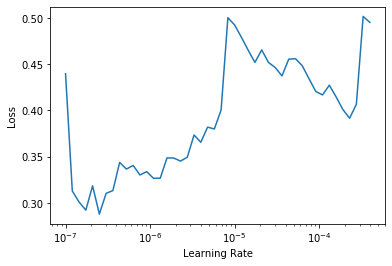

In [37]:
learn.lr_find(suggestions=True)

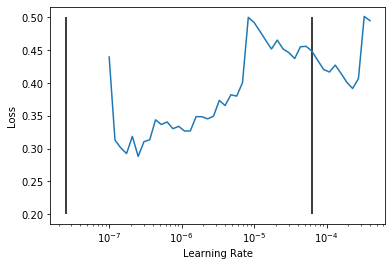

In [38]:
learn.recorder.plot_lr_find()
plt.vlines(2.51e-08, 0.2, 0.5)
plt.vlines(6.30e-05, 0.2, 0.5)

In [39]:
learn.fit_one_cycle(3, lr_max=slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.432284,0.408397,0.830000,00:45
1,0.338886,0.361615,0.840000,00:46
2,0.308777,0.347567,0.860000,00:45


In [40]:
learn.save('roberta-fasthugs-stg2-3e-5')

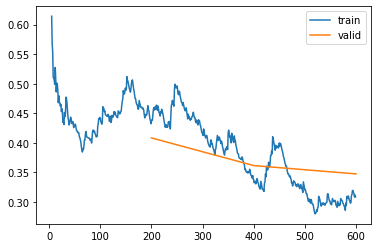

In [41]:
learn.recorder.plot_loss()

## Lets Look at the model's predictions

In [42]:
learn.predict("This was a really good movie, i loved it")

('positive', tensor(1), tensor([0.3457, 0.6543]))

In [43]:
from fastai2.interpret import *
interp = Interpretation.from_learner(learn)

In [44]:
interp.plot_top_losses(3)

,input,target,predicted,probability,loss
0,"<s> ĠIn Ġ17 th ĠCentury ĠJapan , Ġthere Ġlived Ġa Ġsamurai Ġwho Ġwould Ġset Ġthe Ġstandard Ġfor Ġthe Ġages . ĠHis Ġname Ġwas ĠMay eda . ĠHe Ġis Ġsent Ġon Ġan Ġepic Ġjourney Ġacross Ġthe Ġworld Ġto Ġacquire Ġ5 , 000 Ġmus cats Ġfrom Ġthe ĠKing Ġof ĠSpain . ĠWhilst Ġat Ġsea Ġa Ġviolent Ġstorm Ġswall ows Ġtheir Ġprecious Ġgold Ġintended Ġto Ġbuy Ġthe Ġweapons Ġand Ġalmost Ġtakes Ġtheir Ġlives . ĠMay eda Ġmust Ġbattle Ġall Ġodds Ġto Ġsurvive Ġand Ġthe Ġsecure Ġthe Ġfate Ġof Ġhis Ġbeloved ĠJapan . ĠShogun ĠMay eda Ġis Ġa Ġmulti Ġmillion Ġdollar Ġaction Ġadventure Ġepic Ġset Ġacross Ġthree Ġcontinents .< br Ġ/ >< br Ġ/> Star ring Ġcinema Ġlegends ĠSho ĠKos ugi Ġ( T ench u : ĠStealth ĠAssassins ), ĠChristopher ĠLee Ġ( Star ĠWars , ĠLord Ġof Ġthe ĠRings ĠTrilogy ), ĠJohn ĠRh ys ĠDavies Ġ( Lord Ġof Ġthe ĠRings ĠTrilogy , ĠIndiana ĠJones",negative,positive,0.9597547650337219,3.212764263153076
1,"<s> ĠIn Ġorder Ġto Ġhold Ġthe Ġpublic 's Ġattention Ġfor Ġthree Ġhours , Ġwe Ġwere Ġtreated Ġnot Ġso Ġmuch Ġto Ġa Ġfamily 's Ġr omp Ġthrough Ġfour Ġgenerations Ġand Ġ120 Ġyears Ġof ĠHungarian Ġhistory , Ġas Ġto Ġsexual Ġlia isons Ġwith Ġa Ġsister , Ġa Ġsister - in - law Ġand Ġother Ġadul ter ies . ĠOh Ġyes , Ġthere Ġwas Ġalso Ġa Ġtotally Ġgrat uitous Ġrape . ĠHaving Ġsaid Ġall Ġthis , Ġthe Ġfirst Ġstory Ġof Ġthe Ġrelationship Ġamong Ġthe Ġchildren Ġof Ġthe Ġpatriarch Ġwas Ġfresh Ġand Ġsens ual Ġ- Ġthanks Ġto ĠJennifer ĠEh le . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>",negative,positive,0.9231846928596497,2.5663509368896484
2,"<s> ĠI 'm Ġgonna Ġtip Ġthe Ġscales Ġhere Ġa Ġbit Ġand Ġsay ĠI Ġenjoyed Ġthis . ĠHowever , Ġthe Ġcartoon Ġis Ġreally Ġonly Ġgoing Ġto Ġappeal Ġto Ġthose Ġwho Ġhave Ġvery Ġabsurd ist Ġtendencies . ĠIt 's Ġdefinitely Ġsomething Ġthat Ġmost Ġpeople Ġwill Ġnot Ġget , Ġas Ġis Ġthe Ġnature Ġof Ġabsurd ism .< br Ġ/ >< br Ġ/> the Ġanimation Ġis Ġhorrible , Ġbut Ġyes , Ġthat 's Ġthe Ġpoint . ĠThe Ġmain Ġcharacter Ġis Ġfoul Ġm out hed , Ġviolent , Ġand Ġstupid . Ġno Ġredeem ing Ġqualities Ġwhatsoever . Ġhis Ġwife Ġshri eks Ġand Ġw ails , Ġapparently Ġjust Ġbarely Ġcapable Ġof Ġthe Ġmost Ġbasic Ġcommunication Ġskills . Ġmost Ġof Ġthese Ġstories Ġcompletely Ġlack Ġany Ġkind Ġof Ġpoint .< br Ġ/ >< br Ġ/> but Ġagain , Ġthat 's Ġthe Ġpoint Ġ;) < br Ġ/ >< br Ġ/> If Ġnon Ġsequ it ers , Ġfoul Ġlanguage ,",positive,negative,0.9138355255126953,2.451498031616211
